# Kunskapskontroll

### Fyll i uppgifterna nedan innan du lämnar in på LearnPoint: 
Namn på samtliga gruppmedlemmar: 

Asami, Guy, Mustafa,  Pawel, Vidar

# Code

##### Importer

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt


##### Läsa in CSV

In [65]:
housing = pd.read_csv('data/housing.csv')


In [66]:
mean_median_house_value = housing['median_house_value'].mean()
print(mean_median_house_value)
median_median_house_value = housing['median_house_value'].median()
print(median_median_house_value)

206855.81690891474
179700.0


#### Överblicka datan

In [67]:
print(housing.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
None


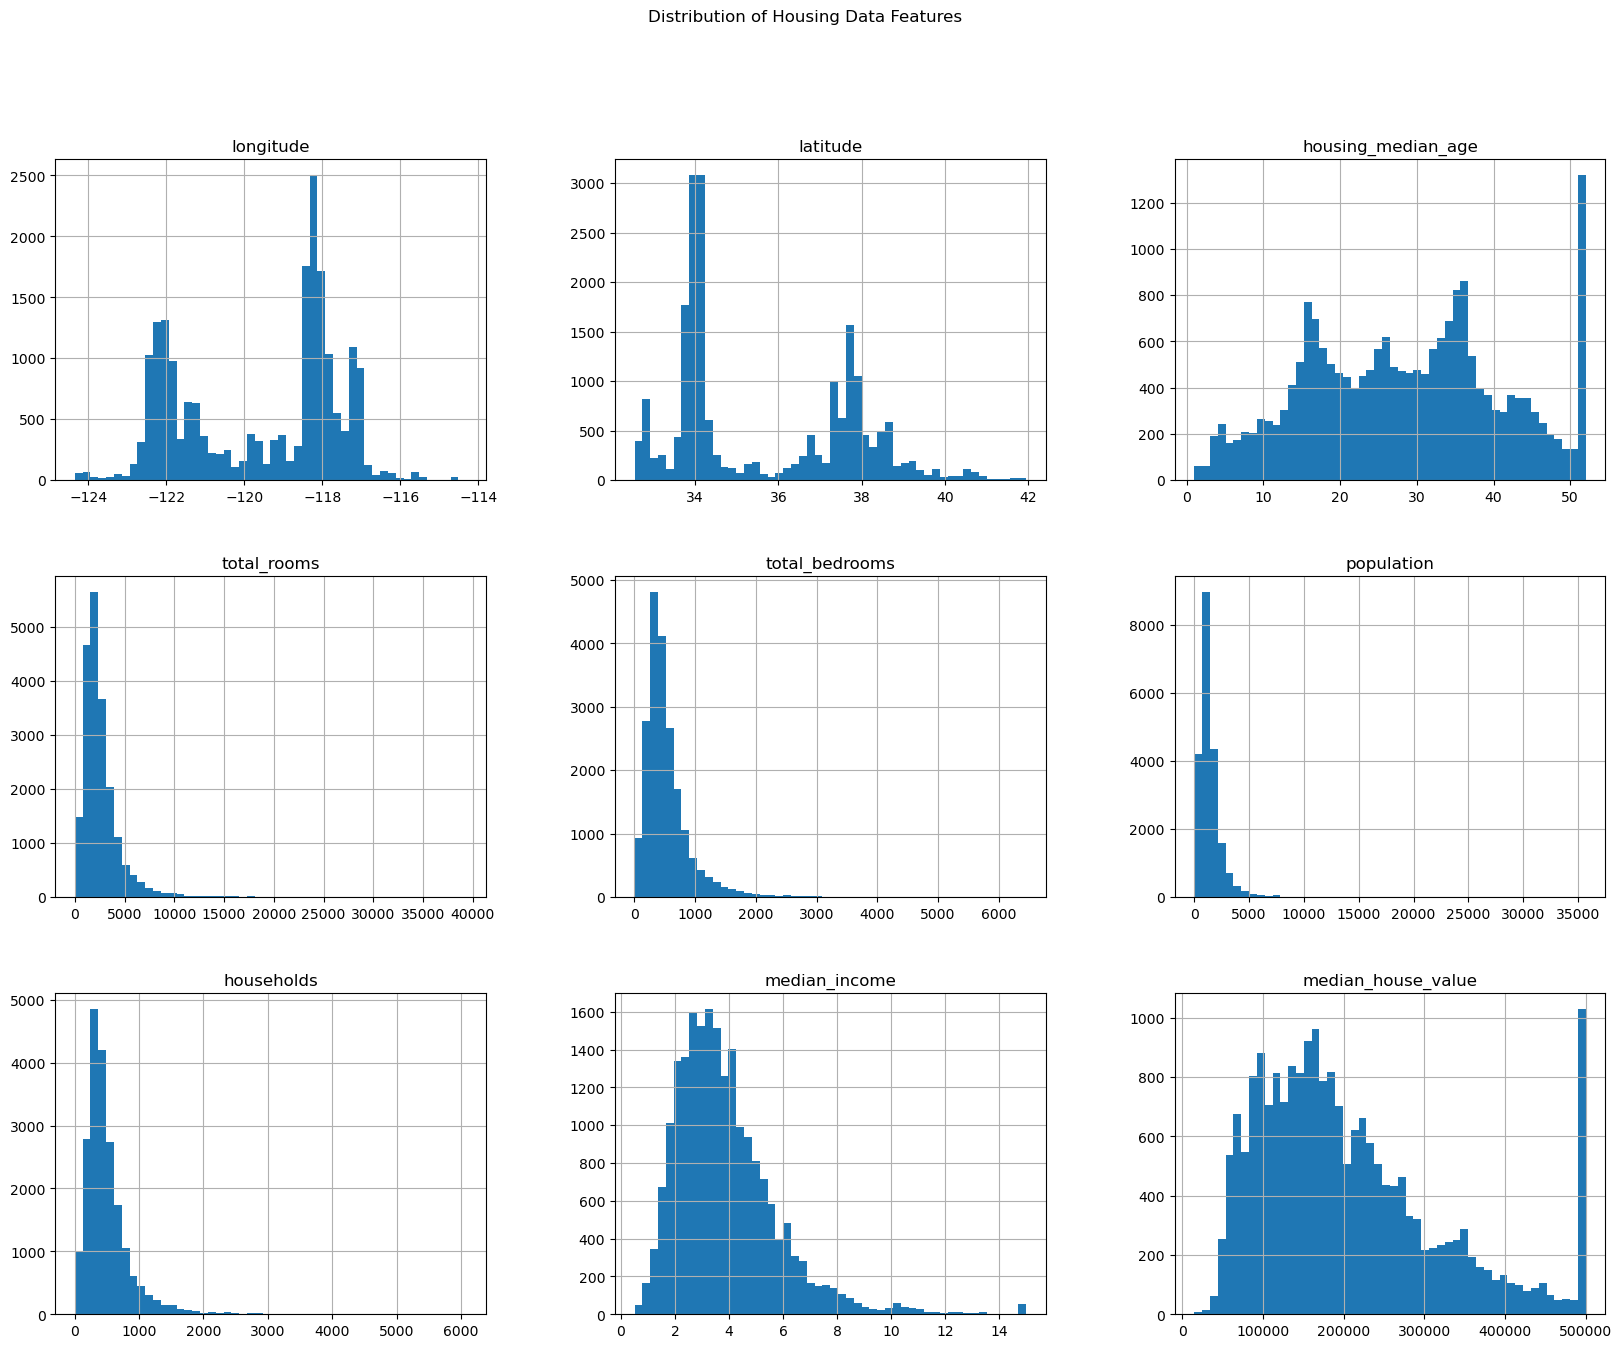

In [68]:
housing.hist(bins=50, figsize=(20,15))
plt.suptitle('Distribution of Housing Data Features')  # Adds a title above all subplots
plt.show()

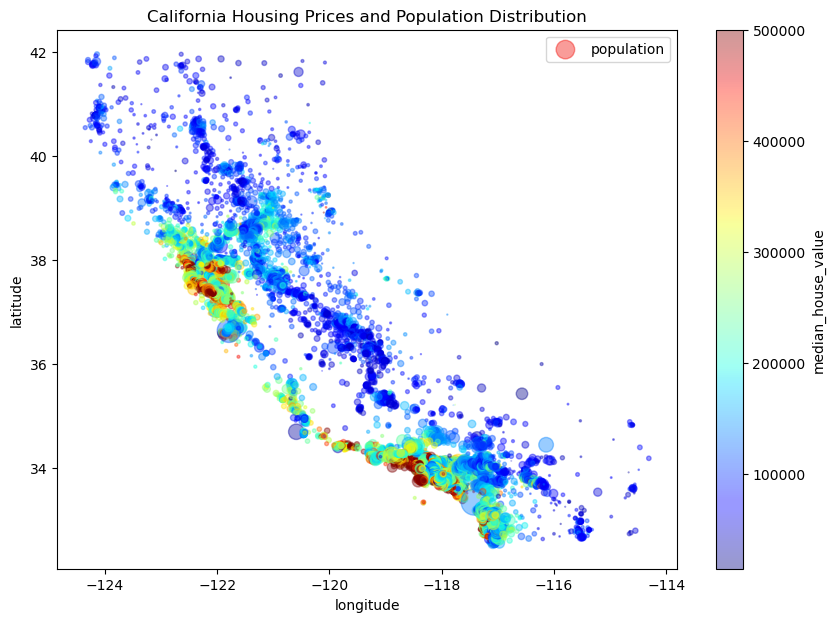

In [69]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()
plt.title('California Housing Prices and Population Distribution')
plt.show()


In [70]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

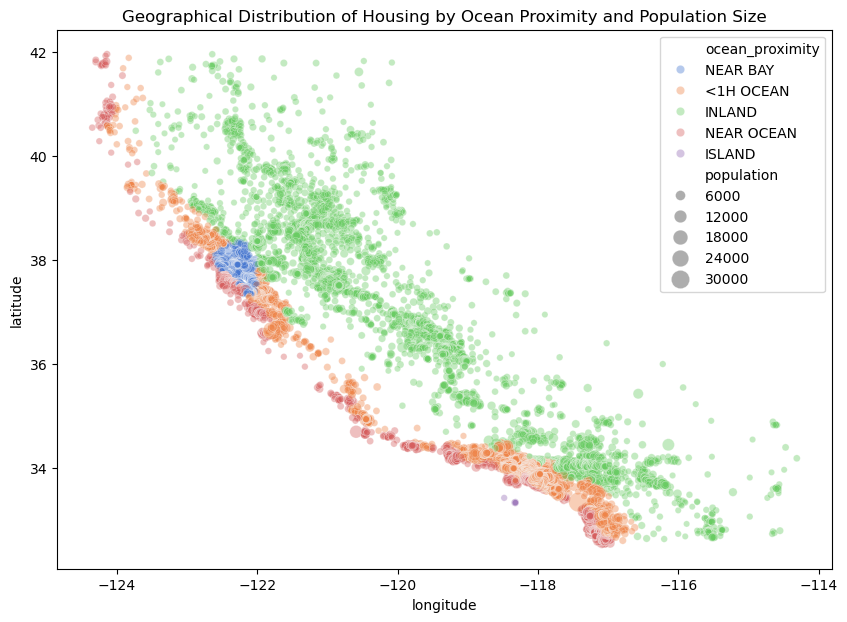

In [71]:
plt.figure(figsize=(10,7))
sns.scatterplot(x="longitude", y="latitude", hue="ocean_proximity", 
                size="population", sizes=(20,200), alpha=0.4, 
                palette="muted", data=housing)

plt.legend()

plt.title('Geographical Distribution of Housing by Ocean Proximity and Population Size')

plt.show()


#### Förbered data
- Ta bort > 500,000 från kolumnen median_house_value
- Ta bort > 51 från kolumnen median_house_age
- Konvertera ocean_proximity med ordinal encoding (1-4), ta bort ISLAND
- Fyll tomma värden med medelvärde/median i kolumnen total_bedrooms

In [72]:
# Filter the data and assign it to a new DataFrame
filtered_housing = housing[(housing['median_house_value'] <= 500000) & (housing['housing_median_age'] <= 51) & (housing['ocean_proximity'] != 'ISLAND')].copy()


In [73]:
category_mapping = {'INLAND': 0, '<1H OCEAN': 1, 'NEAR OCEAN': 2, 'NEAR BAY': 3}
categories = list(category_mapping.keys())
encoder = OrdinalEncoder(categories=[categories])
filtered_housing['ocean_proximity_encoded'] = encoder.fit_transform(filtered_housing[['ocean_proximity']])


In [74]:
# Calculate the mean of the 'total_bedrooms' column in filtered_housing
mean_total_bedrooms = filtered_housing['total_bedrooms'].mean()

# Fill the missing values with the mean in filtered_housing
filtered_housing.loc[:, 'total_bedrooms'] = filtered_housing['total_bedrooms'].fillna(mean_total_bedrooms)


##### Jämföra ny data med hjälp av tabell och diagram
 


Original Data:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000



Filtered Data:


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity_encoded
count,18570.000000,18570.000000,18570.000000,18570.000000,18570.000000,18570.000000,18570.000000,18570.000000,18570.000000,18570.000000
mean,-119.485046,35.593468,26.983737,2668.999677,548.023616,1470.488530,508.749004,3.693403,189588.314324,0.952504
std,1.980939,2.147706,11.432421,2223.891412,427.210029,1162.969265,389.578268,1.570069,95773.639020,0.895718
min,-124.300000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,0.000000
25%,-121.550000,33.920000,17.000000,1455.000000,301.000000,811.000000,284.000000,2.537325,115400.000000,0.000000
50%,-118.450000,34.240000,27.000000,2142.000000,445.000000,1203.000000,416.000000,3.468800,171200.000000,1.000000
75%,-117.970000,37.670000,36.000000,3184.000000,655.000000,1781.000000,614.000000,4.616100,243200.000000,1.000000
max,-114.310000,41.950000,51.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500000.000000,3.000000


<class 'pandas.core.frame.DataFrame'>
Index: 18570 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   longitude                18570 non-null  float64
 1   latitude                 18570 non-null  float64
 2   housing_median_age       18570 non-null  float64
 3   total_rooms              18570 non-null  float64
 4   total_bedrooms           18570 non-null  float64
 5   population               18570 non-null  float64
 6   households               18570 non-null  float64
 7   median_income            18570 non-null  float64
 8   median_house_value       18570 non-null  float64
 9   ocean_proximity          18570 non-null  object 
 10  ocean_proximity_encoded  18570 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.7+ MB
None


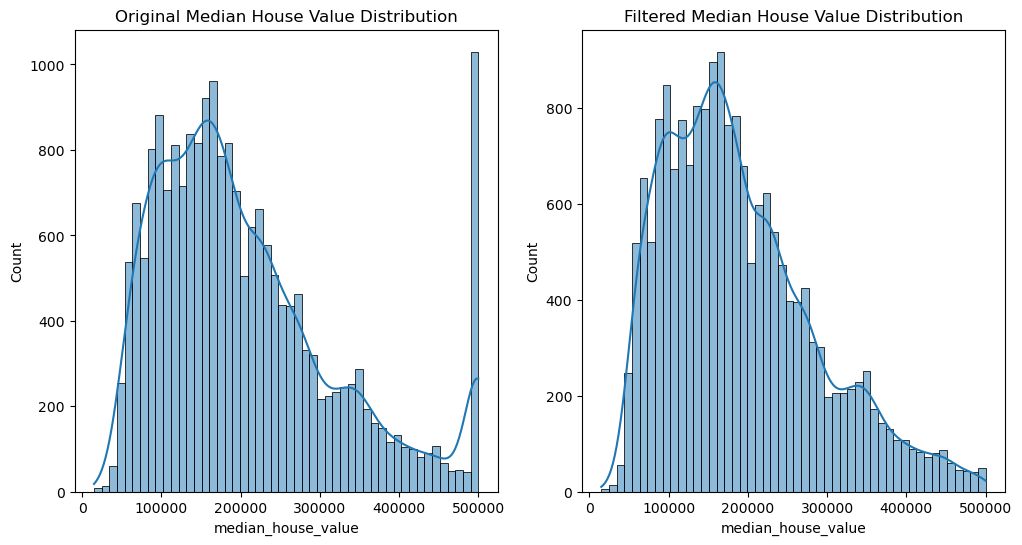

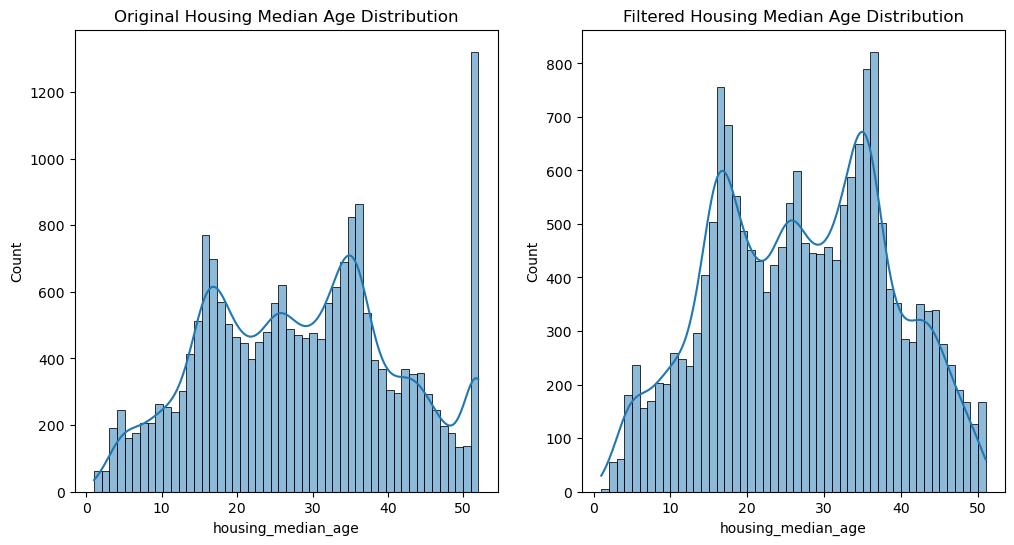

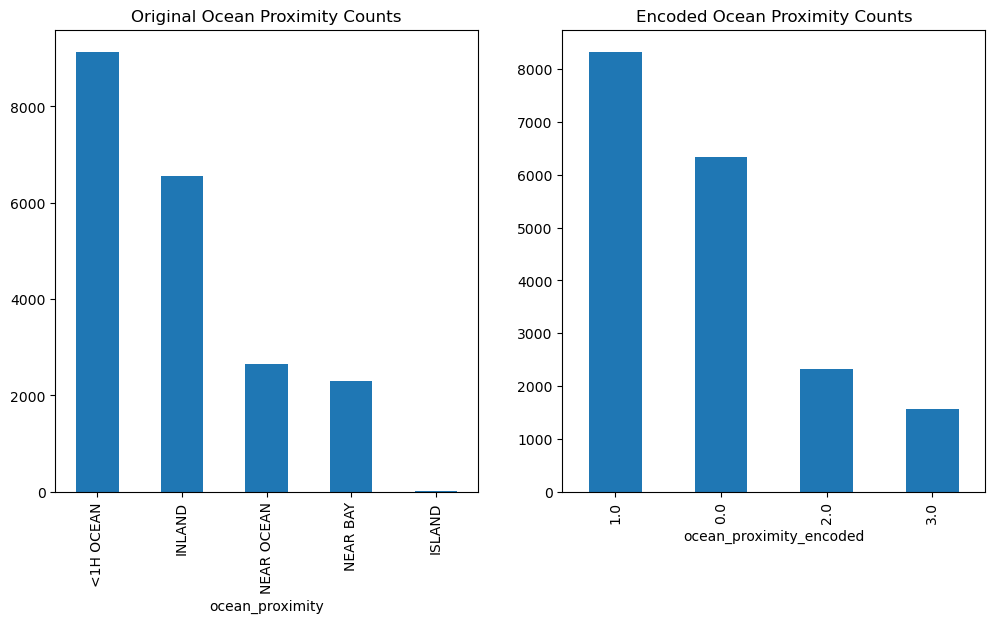

In [75]:
original_housing = housing.copy()

print("Original Data:")
display(original_housing.describe())
print("\nFiltered Data:")
display(filtered_housing.describe())

print(filtered_housing.info())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(original_housing['median_house_value'], bins=50, kde=True)
plt.title('Original Median House Value Distribution')
plt.subplot(1, 2, 2)
sns.histplot(filtered_housing['median_house_value'], bins=50, kde=True)
plt.title('Filtered Median House Value Distribution')
plt.show()

plt.figure(figsize=(12, 6))

# Plot for the original housing data
plt.subplot(1, 2, 1)
sns.histplot(original_housing['housing_median_age'], bins=50, kde=True)
plt.title('Original Housing Median Age Distribution')

# Plot for the filtered housing data
plt.subplot(1, 2, 2)
sns.histplot(filtered_housing['housing_median_age'], bins=50, kde=True)
plt.title('Filtered Housing Median Age Distribution')

plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
original_housing['ocean_proximity'].value_counts().plot(kind='bar')
plt.title('Original Ocean Proximity Counts')
plt.subplot(1, 2, 2)
filtered_housing['ocean_proximity_encoded'].value_counts().plot(kind='bar')
plt.title('Encoded Ocean Proximity Counts')
plt.show()





### Hitta vilka variablar/features att ha med testdata 

<Axes: >

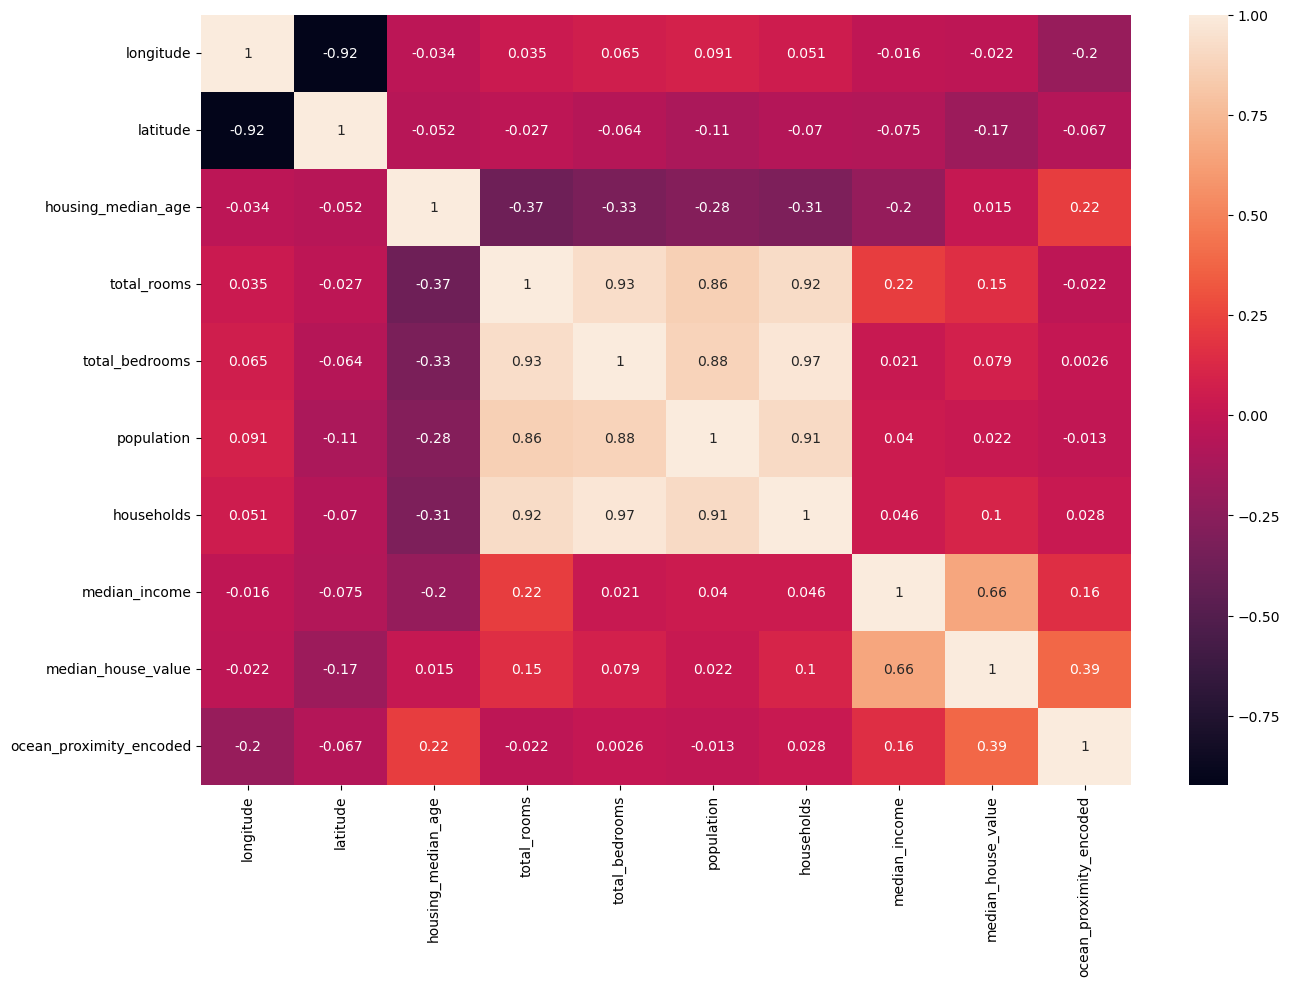

In [76]:
housing_float = filtered_housing.copy()
housing_float = housing_float.drop(['ocean_proximity'], axis=1)
corr_matrix = housing_float.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True)

#### Prova nya variablar

In [77]:
housing_variables = housing_float.copy()

housing_variables["rooms_per_household"] = housing_variables["total_rooms"]/housing_variables["households"]
housing_variables["bedrooms_per_room"] = housing_variables["total_bedrooms"]/housing_variables["total_rooms"]
housing_variables["population_per_household"]=housing_variables["population"]/housing_variables["households"]
# housing_variables["bedrooms_per_household"] = housing_variables["total_bedrooms"]/housing_variables["households"]
housing_variables["population_per_bedroom"]=housing_variables["population"]/housing_variables["total_bedrooms"]


<Axes: >

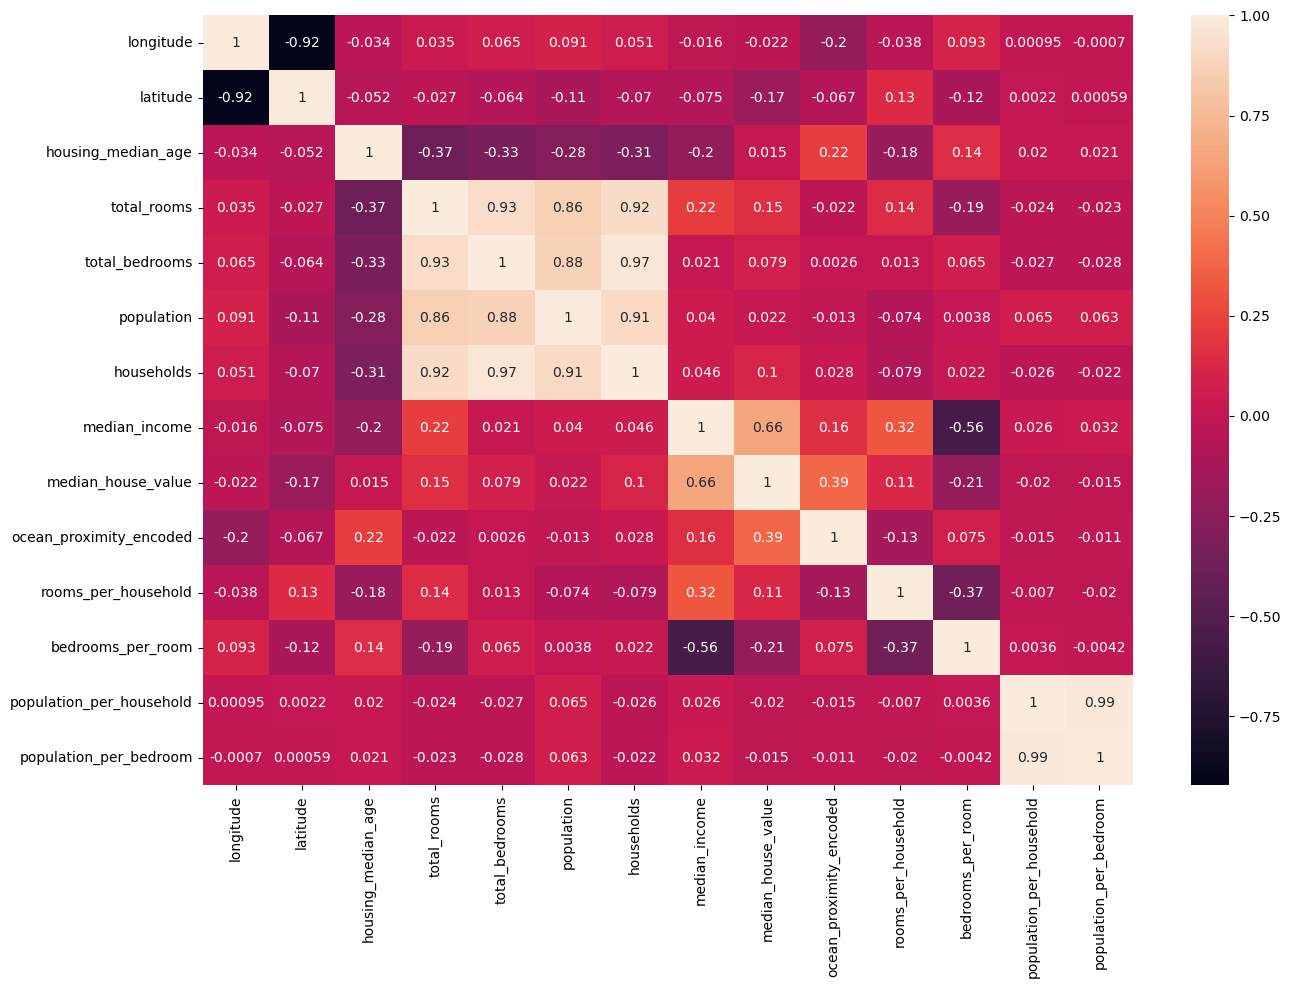

In [78]:

corr_matrix = housing_variables.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True,)

In [79]:
corr_matrix = housing_variables.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)


median_house_value          1.000000
median_income               0.661396
ocean_proximity_encoded     0.388850
total_rooms                 0.152758
rooms_per_household         0.113919
households                  0.100359
total_bedrooms              0.079355
population                  0.021763
housing_median_age          0.014765
population_per_bedroom     -0.015343
population_per_household   -0.020337
longitude                  -0.022284
latitude                   -0.171967
bedrooms_per_room          -0.206709
Name: median_house_value, dtype: float64

In [80]:
housing_variables['median_house_value'].describe()


count     18570.000000
mean     189588.314324
std       95773.639020
min       14999.000000
25%      115400.000000
50%      171200.000000
75%      243200.000000
max      500000.000000
Name: median_house_value, dtype: float64

In [81]:
housing_variables.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18570 entries, 0 to 20639
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 18570 non-null  float64
 1   latitude                  18570 non-null  float64
 2   housing_median_age        18570 non-null  float64
 3   total_rooms               18570 non-null  float64
 4   total_bedrooms            18570 non-null  float64
 5   population                18570 non-null  float64
 6   households                18570 non-null  float64
 7   median_income             18570 non-null  float64
 8   median_house_value        18570 non-null  float64
 9   ocean_proximity_encoded   18570 non-null  float64
 10  rooms_per_household       18570 non-null  float64
 11  bedrooms_per_room         18570 non-null  float64
 12  population_per_household  18570 non-null  float64
 13  population_per_bedroom    18570 non-null  float64
dtypes: float64(

#### Använda RandomForestRegressor för att hitta de viktigaste variablarna/features


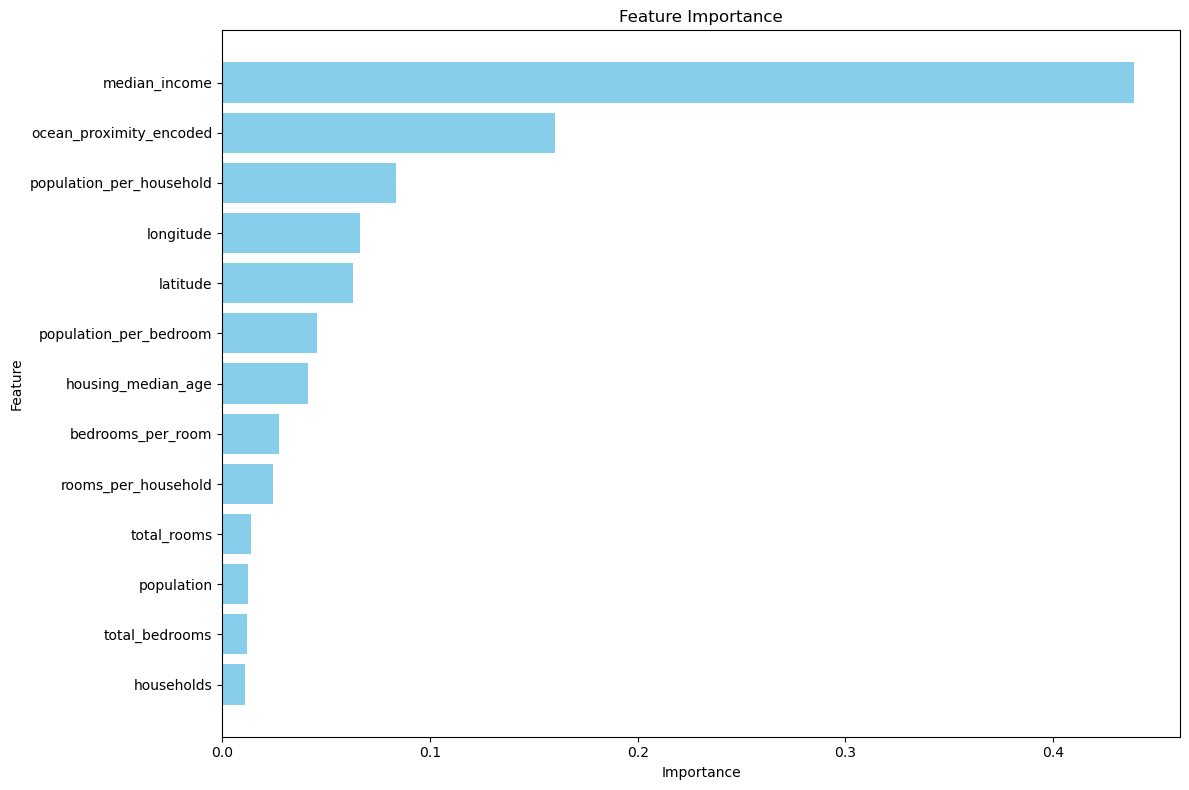

In [82]:
X = housing_variables.drop('median_house_value', axis=1)
y = housing_variables['median_house_value']

rf_reg = RandomForestRegressor()
rf_reg.fit(X, y)

importance = rf_reg.feature_importances_

feature_names = X.columns


sorted_idx = np.argsort(importance)
sorted_feature_names = feature_names[sorted_idx]
sorted_importance = importance[sorted_idx]

plt.figure(figsize=(12, 8))  
plt.barh(sorted_feature_names, sorted_importance, color='skyblue')  
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.tight_layout()  
plt.show()

# Börja träna modeller

In [83]:
median_median_house_value_no_outliers = housing_variables['median_house_value'].mean()
print(median_median_house_value_no_outliers)

189588.3143241788


In [84]:
final_data = housing_variables[['median_house_value', 'median_income', 'ocean_proximity_encoded', 'population_per_household']].copy()
final_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18570 entries, 0 to 20639
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   median_house_value        18570 non-null  float64
 1   median_income             18570 non-null  float64
 2   ocean_proximity_encoded   18570 non-null  float64
 3   population_per_household  18570 non-null  float64
dtypes: float64(4)
memory usage: 725.4 KB


In [85]:
final_ll_data = housing_variables[['median_house_value', 'median_income', 'ocean_proximity_encoded', 'population_per_household', 'longitude', 'latitude']].copy()
final_ll_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18570 entries, 0 to 20639
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   median_house_value        18570 non-null  float64
 1   median_income             18570 non-null  float64
 2   ocean_proximity_encoded   18570 non-null  float64
 3   population_per_household  18570 non-null  float64
 4   longitude                 18570 non-null  float64
 5   latitude                  18570 non-null  float64
dtypes: float64(6)
memory usage: 1015.5 KB


### Skapa testdata

In [86]:
X = final_ll_data.drop('median_house_value', axis=1)
y = final_ll_data['median_house_value']
# X = final_data.drop('median_house_value', axis=1)
# y = final_data['median_house_value']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

### Linear Regression

In [87]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [88]:
lin_reg_pred_val = lin_reg.predict(X_val)
rmse_lin_reg = mean_squared_error(y_val, lin_reg_pred_val, squared=False)
print(f"Linear Regression RMSE: {rmse_lin_reg}")
print(f"Error rate %: {round(rmse_lin_reg/y_train_full.mean()*100, 2)}")


Linear Regression RMSE: 61273.377546805554
Error rate %: 32.39


##### Visualization of prediction for linear regression

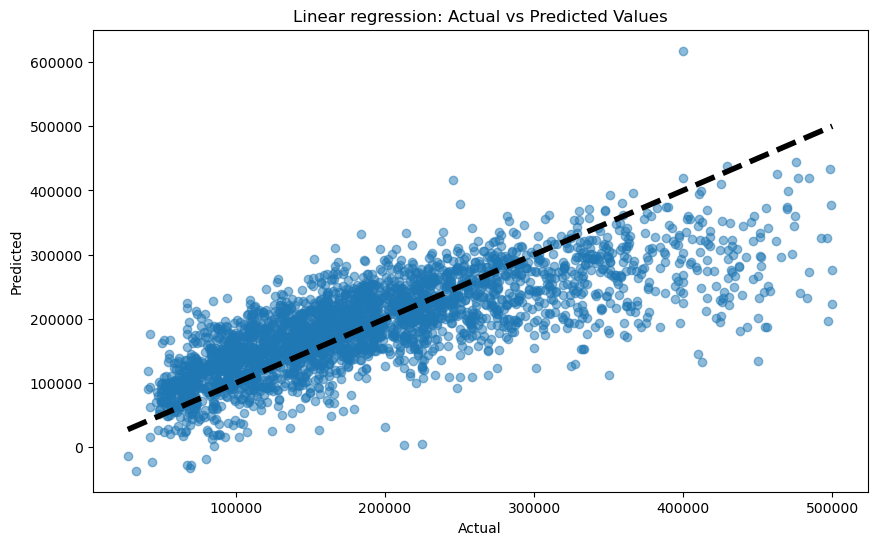

In [89]:

plt.figure(figsize=(10, 6))
plt.scatter(y_val, lin_reg_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear regression: Actual vs Predicted Values')
plt.show()

### Support Vector Regressor

In [90]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val) 
X_test_scaled = scaler.transform(X_test) 

svr_reg = SVR()

# Parameter grid for GridSearchCV
param_grid = {'kernel': ['rbf', 'poly'], 'gamma': [1, 2], 'C': [0.5, 1, 1.5]}

grid_search = GridSearchCV(svr_reg, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_val_scaled)

# mean_squared_error(y_true, y_pred, squared=False)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print(f'Best parameters found: {grid_search.best_params_}')
# print(f'Mean Squared Error: {mse}')
# print(f'Root Mean Squared Error: {rmse}')
# print(f"Error rate %: {round(rmse/y_train_full.mean()*100, 2)}")


Best parameters found: {'C': 1.5, 'gamma': 1, 'kernel': 'poly'}


##### Best SVR regression hyperparameters

In [91]:
svr_reg_best = SVR(C= 1.5, gamma= 1, kernel= 'poly')
svr_reg_best.fit(X_train_scaled, y_train)
y_pred_svr_best = svr_reg_best.predict(X_val_scaled)

mse_svr_best = mean_squared_error(y_val, y_pred_svr_best)
rmse_svr_best = np.sqrt(mse_svr_best)
print(f"SVR RMSE: {rmse_svr_best}")
print(f"Error rate %: {round(rmse_svr_best/y_train_full.mean()*100, 2)}")


SVR RMSE: 81087.14833246206
Error rate %: 42.86


##### Vizualisation of prediction in SVR

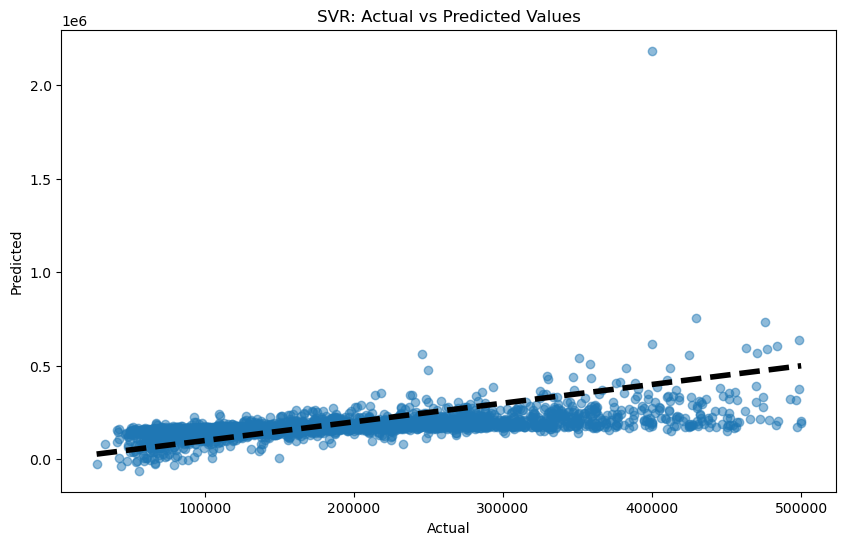

In [92]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('SVR: Actual vs Predicted Values')
plt.show()


### RandomforestRegressor


In [93]:
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

forest_reg.fit(X_train, y_train)

y_pred = forest_reg.predict(X_val)

mse = mean_squared_error(y_val, y_pred)

rmse = sqrt(mse)

print(f"Validerings RMSE: {rmse}")

Validerings RMSE: 43768.998365727115


##### Hittar bästa Hyperparameterna

In [94]:
param_grid = [
 {'n_estimators': [3, 10, 30,], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Bästa parametrarna: {best_params}")

best_estimator = grid_search.best_estimator_
print(f"Bästa estimatorn: {best_estimator}")



Bästa parametrarna: {'max_features': 2, 'n_estimators': 30}
Bästa estimatorn: RandomForestRegressor(max_features=2, n_estimators=30)


##### Använder the bäst hittade Hyperparametrarna

In [95]:
best_params = grid_search.best_params_
forest_reg_best = RandomForestRegressor(**best_params)

forest_reg_best.fit(X_train, y_train)

best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_val)

mse = mean_squared_error(y_val, y_pred)
rmse = sqrt(mse)

print(f"Validerings RMSE: {rmse}")
print(f"Error rate %: {round(rmse/y_train_full.mean()*100, 2)}")
print(f"Error rate % (whole dataset): {round(rmse/mean_median_house_value*100, 2)}")



Validerings RMSE: 42229.1605710793
Error rate %: 22.32
Error rate % (whole dataset): 20.41


##### Vizualization of prediction of RandomForestRegressor

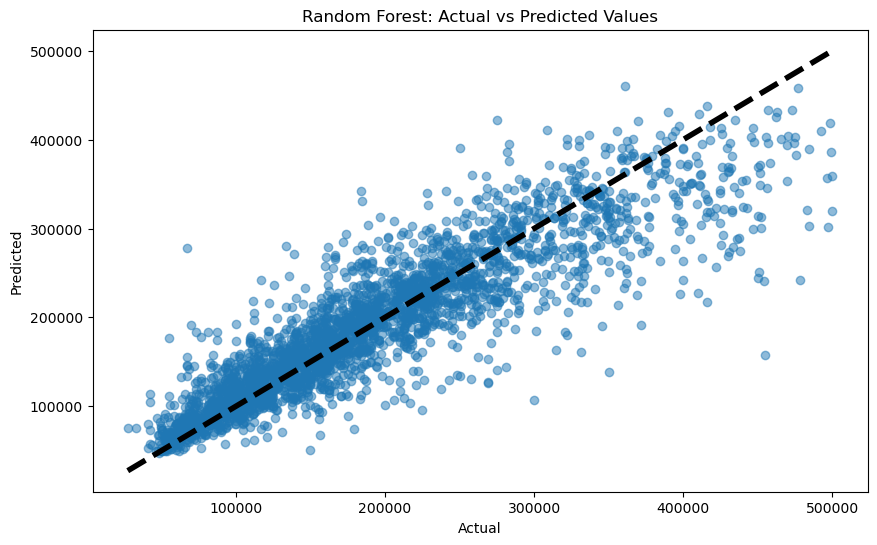

In [96]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Actual vs Predicted Values')
plt.show()


### Compare the different modells

##### Calculate cross-validation score

In [97]:
from sklearn.model_selection import cross_val_score

# Linear Regression
lin_reg_scores = cross_val_score(lin_reg, X, y, scoring='neg_mean_squared_error', cv=10)
lin_reg_rmse_scores = np.sqrt(-lin_reg_scores)

# SVR
svr_scores = cross_val_score(svr_reg_best, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=10)
svr_rmse_scores = np.sqrt(-svr_scores)

# Random Forest
forest_scores = cross_val_score(forest_reg_best, X, y, scoring='neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

print(f"Linear Regression RMSE: {lin_reg_rmse_scores.mean()} (std: {lin_reg_rmse_scores.std()})")
print(f"SVR RMSE: {svr_rmse_scores.mean()} (std: {svr_rmse_scores.std()})")
print(f"Random Forest RMSE: {forest_rmse_scores.mean()} (std: {forest_rmse_scores.std()})")


Linear Regression RMSE: 64231.286371127855 (std: 11484.200156274143)
SVR RMSE: 76925.47052977383 (std: 4190.815176850832)
Random Forest RMSE: 55499.67863170746 (std: 9733.732780428047)


##### Prestanda CVS

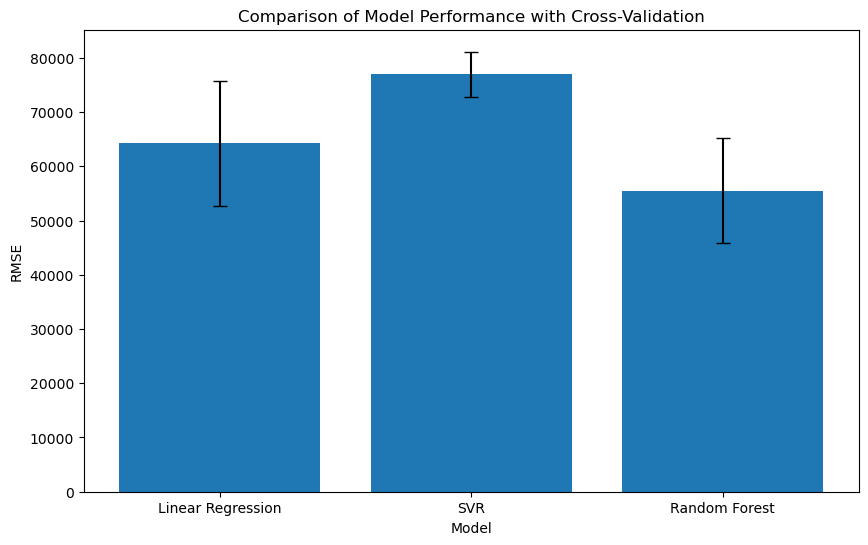

In [98]:
models = ['Linear Regression', 'SVR', 'Random Forest']
rmse_means = [lin_reg_rmse_scores.mean(), svr_rmse_scores.mean(), forest_rmse_scores.mean()]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_means, yerr=[lin_reg_rmse_scores.std(), svr_rmse_scores.std(), forest_rmse_scores.std()], capsize=5)
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('Comparison of Model Performance with Cross-Validation')
plt.show()


##### Jämförelse mellan modellernas RSME

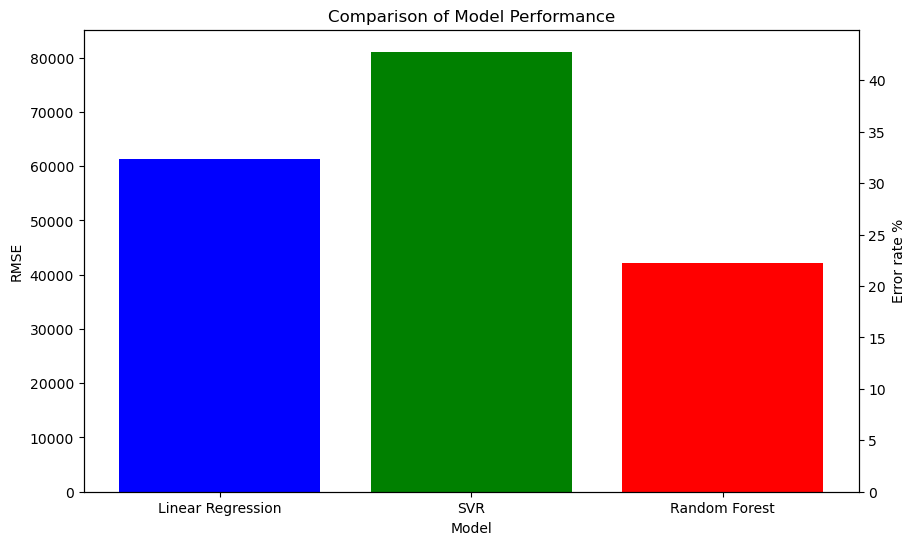

In [99]:
models = ['Linear Regression', 'SVR', 'Random Forest']

rmse_values = [rmse_lin_reg, rmse_svr_best, rmse]
percent_values = [(value / median_median_house_value_no_outliers) * 100 for value in rmse_values]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(models, rmse_values, color=['blue', 'green', 'red'])
ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE', color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
ax2.set_ylabel('Error rate %', color='black')  # customize label as needed
ax2.tick_params(axis='y', labelcolor='black')

ax2.set_ylim(ax1.get_ylim()[0] / median_median_house_value_no_outliers * 100, ax1.get_ylim()[1] / median_median_house_value_no_outliers * 100)

plt.title('Comparison of Model Performance')

plt.show()





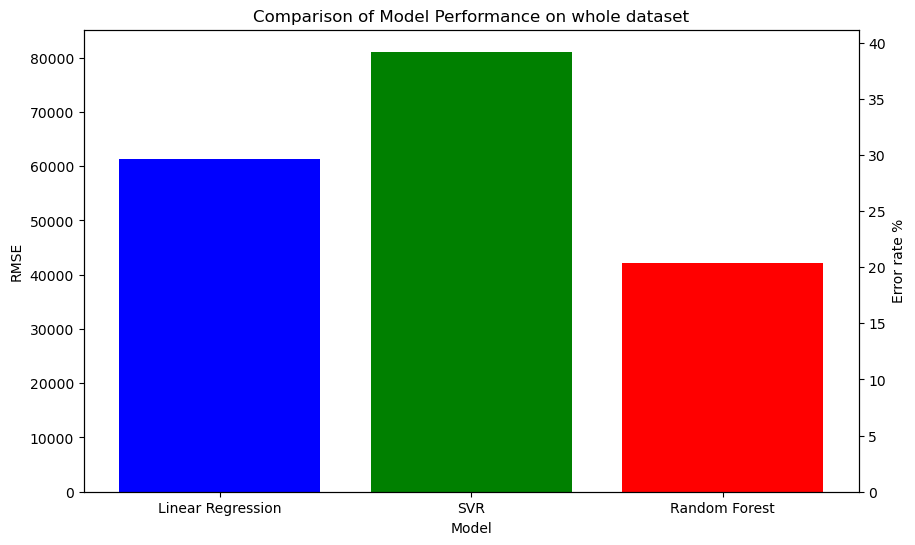

In [100]:
# This code creates a chart that displays the error rate based upon RMSE divided by mean of the median house value for the whole dataset, including outliers

models = ['Linear Regression', 'SVR', 'Random Forest']

rmse_values = [rmse_lin_reg, rmse_svr_best, rmse]
percent_values = [(value / mean_median_house_value) * 100 for value in rmse_values]

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(models, rmse_values, color=['blue', 'green', 'red'])
ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE', color='black')
ax1.tick_params(axis='y', labelcolor='black')

ax2 = ax1.twinx()
ax2.set_ylabel('Error rate %', color='black')  # customize label as needed
ax2.tick_params(axis='y', labelcolor='black')

ax2.set_ylim(ax1.get_ylim()[0] / mean_median_house_value* 100, ax1.get_ylim()[1] / mean_median_house_value * 100)

plt.title('Comparison of Model Performance on whole dataset')

plt.show()





##### Error i %

### Köra bästa modellen på testdatan

In [101]:
best_params = grid_search.best_params_
forest_reg_best = RandomForestRegressor(**best_params)
 
forest_reg_best.fit(X_train_full, y_train_full)
 
y_pred_test = forest_reg_best.predict(X_test)
 
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
 
print(f"Test RMSE: {rmse_test}")
print(f"Error rate %: {round(rmse_test/y.mean()*100, 2)}")


Test RMSE: 43525.99450998491
Error rate %: 22.96
